# Automatic Building Footprint Extraction Using Satellite RGB and LiDAR Elevation

In this notebook, we will show how to utilize both SpaceNet satellite image and USGS 3DEP LiDAR data (elevation attribute) to automatically extract building footprints. This task was used in three previous SpaceNet challenges: 1st, 2nd, and 4th.

## Setup

_This notebook was created and tested on an ml.p3.8xlarge notebook instance._

First of all, if you haven't done so, please follow instructions in `README.md` to run `setup-env.sh` and `download-from-s3.sh` scripts to properly set up the Conda environment and download necessary files from S3 buckets prepared for this tutorial. Before proceeding, make sure this notebook connects with the proper kernel (`conda_[name]`, `[name]` is name of the new Conda environment you just created).

In [1]:
import os, time, json, random
from pathlib import Path
from tqdm import tqdm
from p_tqdm import p_umap
import numpy as np
import pandas as pd
import skimage
import torch
from torch import nn

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### External modules

We made some customized modification to the external module `solaris` in `libs/` directory. Please refer to their [GitHub page](https://github.com/CosmiQ/solaris) for more information.

In [2]:
import libs.solaris as sol

2022-11-06 10:09:42.843904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 10:09:43.751558: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Plotting preferences

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

/tmp/ipykernel_14714/3301049148.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


## Data

The datasets used in this notebook are saved in directory `./data/buildings/`.

1. **SpaceNet satellite images**:
There are 3850 tiles ("chips") of 200m$\times$200m satellite images/labels in this training dataset (`SN2/AOI_2_Vegas`). See [link](https://spacenet.ai/las-vegas/) for more information. We extract the ~0.3m resolution pan-sharpened RGB (`PS-RGB`) 3-channel satellite images and perform white balancing. On the other hand, the `geojson_buildings/` directory contains GeoJSON files for building ground truths.

2. **USGS 3DEP LiDAR**:
This is [a large USGS project](https://www.usgs.gov/core-science-systems/ngp/3dep) that covers many regions throughout US. Also see [here](https://usgs.entwine.io/) for cool visualizations. We extract 3D point clouds in Las Vegas region that overlap with the SpaceNet data, project them into corresponding 2D tiles (3084 in total). The LiDAR data have two attributes: elevation and reflection intensity. For building extraction, we will use the elevation attribute after normalizing the elevation values.

At the end, we merge the LiDAR elevation attribute as an additional channel to the RGB image, and save these 4-channel images to `RGB+ELEV/` directory.

In [4]:
data_dir = './data/buildings/'
img_dir = os.path.join(data_dir, 'RGB+ELEV')
bldg_dir = os.path.join(data_dir, 'geojson_buildings')

# Prefix of all filename - naming convention
prefix = 'SN2_buildings_train_AOI_2_Vegas_'

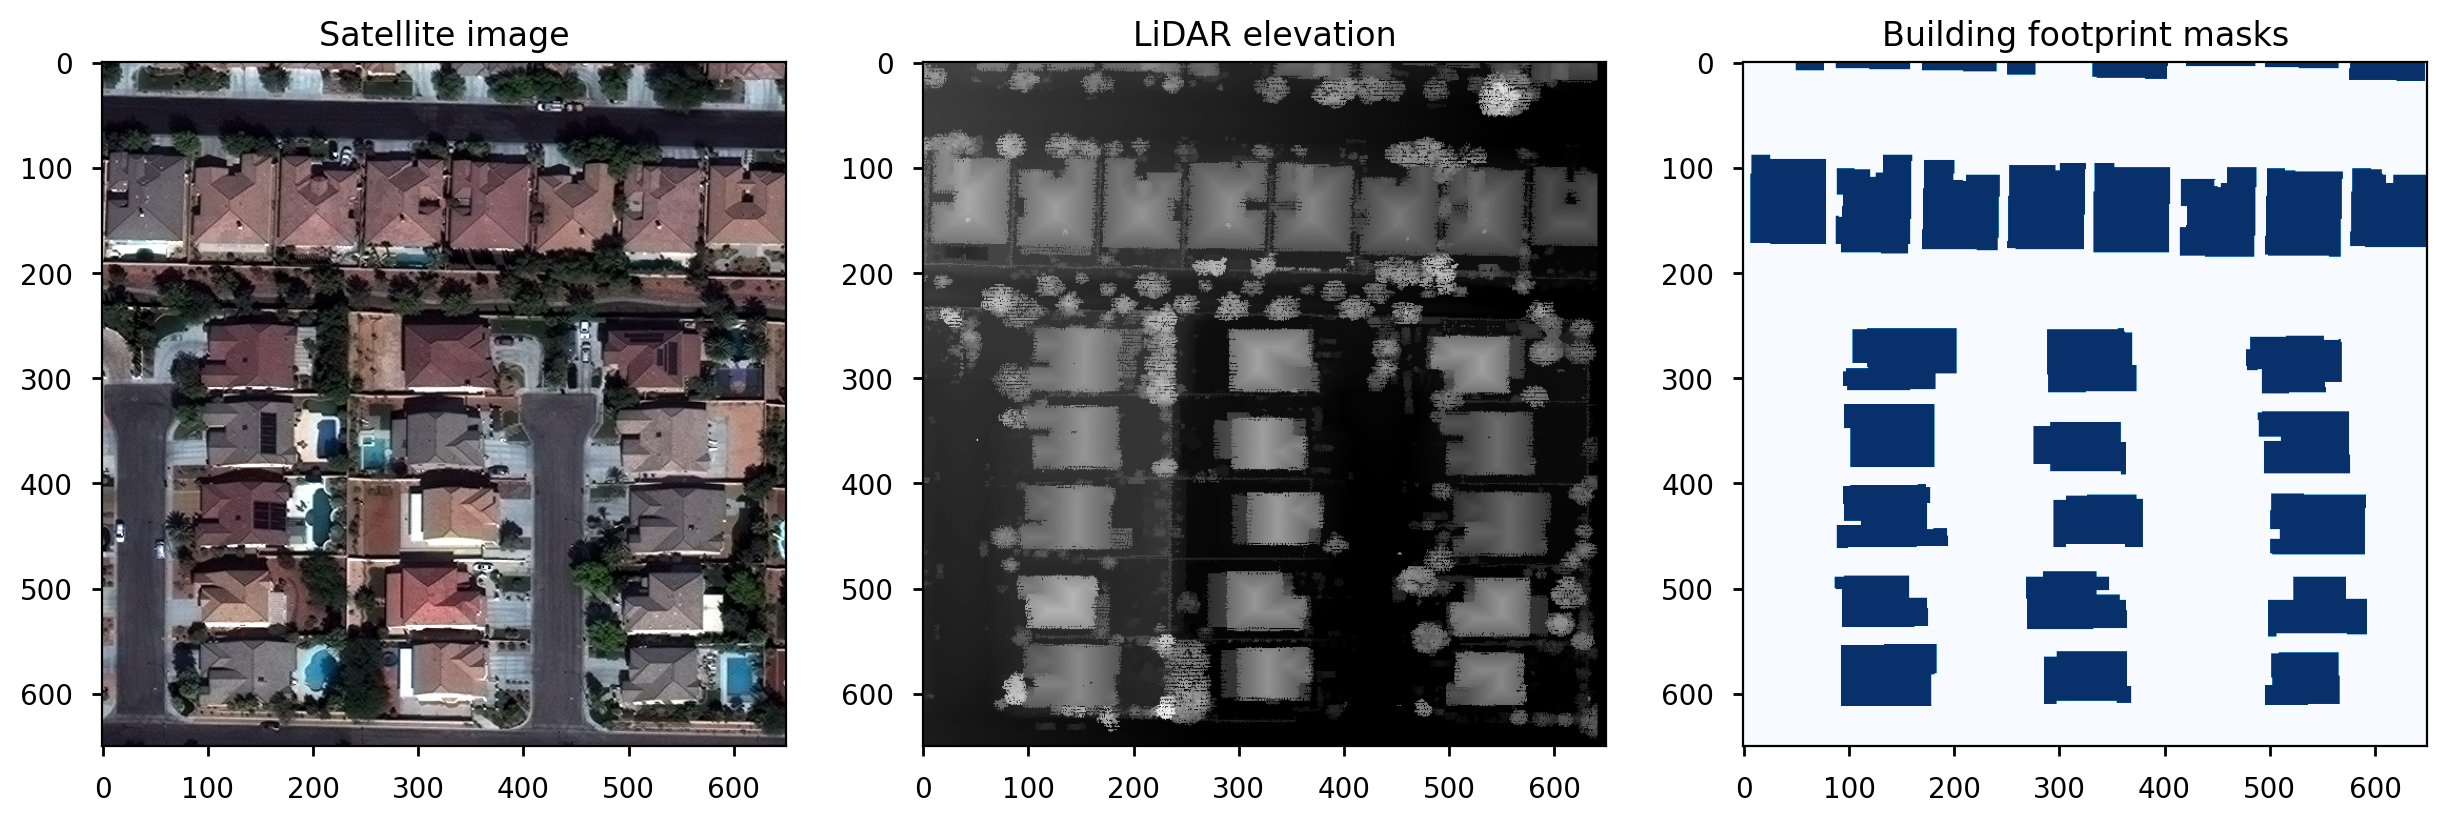

In [5]:
# Show a data sample
sample = 'img1423' # chip ID, img? format

# Read in 4-channel image from GeoTIFF.
img_file = prefix + 'RGB+ELEV_' + sample + '.tif'
img_path = os.path.join(img_dir, img_file)
img = skimage.io.imread(img_path)
rgb = img[..., :3]
elev = img[..., -1]

# Read in GeoJSON file and convert polygons to footprint mask.
bldg_file = prefix + 'geojson_buildings_' + sample + '.geojson'
bldg_path = os.path.join(bldg_dir, bldg_file)
mask = sol.vector.mask.footprint_mask(bldg_path, reference_im=img_path)

# Display satellite image and building footprint mask.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(rgb)
ax[0].set_title('Satellite image')
ax[1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
ax[1].set_title('LiDAR elevation')
ax[2].imshow(mask, cmap='Blues')
ax[2].set_title('Building footprint masks')
fig.show()

## Train network model

The SpaceNet images come with GeoJSON annotations as polygon vectors. These cannot be directly accepted by neural network; instead, we should convert them to binary mask images (as shown above). These masks will be the "ground truth labels" to train our segmentation network model.

In [6]:
mask_dir = os.path.join(data_dir, 'mask_buildings')

# This step is time-consuming, and only needs to be run once.
# After you have all the mask labels ready in folder `mask_buildings/`,
# this operation will be skipped.
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
    
    img_file_list = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
    for img_file in tqdm(img_file_list):
        # Get the `img[number]` chip ID from file name.
        chip_id = os.path.splitext(img_file)[0].split('_')[-1]
        bldg_file = prefix + 'geojson_buildings_' + chip_id + '.geojson'
        mask_file = prefix + 'mask_buildings_' + chip_id + '.tif'
        
        _ = sol.vector.mask.footprint_mask(
            os.path.join(bldg_dir, bldg_file),
            out_file=os.path.join(mask_dir, mask_file),
            reference_im=os.path.join(img_dir, img_file))

### Split train and test data

SpaceNet provides two groups of data: a `training` directory to train models and `test_public` directory for final inference, scoring, and ranking. Because the ground truth files for `test_public` data are not publicly available, we won't be able to reproduce exactly the winners' score.

On the other hand, we can split a part of `training` data, hold this part of data out as a simulated blind test. The filenames for each data group are saved to CSV file `split_train_data.csv` and `split_blind_test.csv`, respectively. We can split the 3084 image tiles by 30%/70%.

In [7]:
# Get lists of training image/label files.
img_file_list = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
mask_file_list = [f for f in os.listdir(mask_dir) if f.endswith('.tif')]
# Extract the mask files that have corresponding RGB+LIDAR images.
mask_file_subset = [f for f in mask_file_list
    if f.replace('mask_buildings_', 'RGB+ELEV_') in img_file_list]
img_path_list = [os.path.join(img_dir, f) for f in img_file_list]
mask_path_list = [os.path.join(mask_dir, f) for f in mask_file_subset]
assert len(img_path_list) == len(mask_path_list)
# Sort the list by filenames.
img_path_list.sort()
mask_path_list.sort()

# Create Pandas data frame, containing columns 'image' and 'label'.
total_df = pd.DataFrame({'image': img_path_list,
                         'label': mask_path_list})
# Split this data frame to training data and blind test data.
split_mask = np.random.rand(len(total_df)) < 0.7
train_df = total_df[split_mask]
test_df = total_df[~split_mask]

# Save the data frames to CSV files.
train_csv_path = './data/buildings/split_train_data.csv'
test_csv_path = './data/buildings/split_blind_test.csv'
# I have put the CSV files in the notebook directory already; the following;
# CSV output lines are commented out for the sake of consistency.
# If you want to generate your own train/test set, uncomment them, run again.
train_df.to_csv(train_csv_path)
test_df.to_csv(test_csv_path)
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
print('{} images in total, {} - train, {} - test.'.format(
    len(total_df), len(train_df), len(test_df)))

3084 images in total, 2119 - train, 965 - test.


### Training setup

Now that train/test data are ready to go, we will set up the network model training. The library `solaris` helps building a ML pipeline for overhead imagery, which handles data loading, pre-processing, augmentation, model training/inference, and performance evaluation.

For this notebook, all training setups in `.yml` format are saved in directory `configs/buildings/`:
1. `RGB-only.yml`: network only uses RGB images as input (3-channel);
2. `ELEV-only.yml`: network only uses LiDAR elevation images as input (1-channel);
3. `RGB+ELEV.yml`: network uses both RGB and LiDAR elevation as merged input (4-channel).

In the following cell, please select the config file you would like to experiment. After completing this notebook, feel free to come back here, change to other config or create your own setup to see what's different.

In [8]:
# --------------------------------------------#
# Select the config file you want to use
config = sol.utils.config.parse('./configs/buildings/RGB+ELEV.yml')
# --------------------------------------------#

# Link training datasets to config.
config['training_data_csv'] = train_csv_path
config['inference_data_csv'] = test_csv_path

A side note: since we do not explicitly assign `validation_data_csv` in the config, `solaris` will automatically split a random portion (specified by `val_holdout_frac`, in this case 0.05) of training data for validation during training.

Next, let's load a customized VGG16-Unet from `networks/` directory. This algorithm is from the winner `XD_XD` from SpaceNet challenge 4 ([link to repo](https://github.com/SpaceNetChallenge/SpaceNet_Off_Nadir_Solutions/tree/master/XD_XD)). We modified the code so that it takes multi-channel input.

In [9]:
# Load customized multi-channel input VGG16-Unet model.
from networks.vgg16_unet import get_modified_vgg16_unet

custom_model = get_modified_vgg16_unet(
    in_channels=config['data_specs']['channels'])
custom_model_dict = {
    'model_name': 'modified_vgg16_unet',
    'weight_path': None,
    'weight_url': None,
    'arch': custom_model
}

# Create trainer
trainer = sol.nets.train.Trainer(config, custom_model_dict=custom_model_dict)
# Show model architecture
# print(trainer.model)

/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


We are all set for training!

Since training takes a long time, we also provide our trained model weights in `models/buildings/` directory. The next inference section will use these trained weights. However, if your time and resource allows, uncomment and run the following cell to train your own model.

In [11]:
# --------------------------------------------#
# This takes ~1.5 hours to finish (100 epochs).
# Training is skipped by default.
# Uncomment the following line if you want to repeat the trainig process.
# trainer.train()
# --------------------------------------------#

## Inference on sample data

After training, we can test the model by first trying on the sample data displayed earlier.

In [ ]:
custom_model_dict = {
    'model_name': 'modified_vgg16_unet',
    'weight_path': config['training']['model_dest_path'],
    'weight_url': None,
    'arch': custom_model}
config['train'] = False
inferer = sol.nets.infer.Inferer(config, custom_model_dict=custom_model_dict)

sample_df = pd.DataFrame({'image': [img_path]}) # previous sample image
inferer(sample_df)

/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/tutorial_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/1 [00:00<?, ?it/s]

In [1]:
# Load prediction result from the output directory.
pred_dir = config['inference']['output_dir']
pred_file = prefix + 'RGB+ELEV_' + sample + '.tif'
pred_path = os.path.join(pred_dir, pred_file)
pred = skimage.io.imread(pred_path)[..., 0]

# Display satellite image, LiDAR, prediction mask, and ground truth mask.
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb)
ax[0][0].set_title('Satellite image')
ax[0][1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
ax[0][1].set_title('LiDAR elevation')
ax[1][0].imshow(pred>0, cmap='Blues')
ax[1][0].set_title('Predicted footprint')
ax[1][1].imshow(mask, cmap='Blues')
ax[1][1].set_title('Ground truth footprint')
fig.show()

NameError: name 'config' is not defined

The result looks good. Meanwhile, other than visual comparison, a quantitative metric can help us better understand the model's performance. SpaceNet building extraction challenge evaluates models by F-1 scores for IoU>=50%. Now let's evaluate the F-1 score of the result above.

In [13]:
# We convert GeoJSON polygons to binary masks for training and visualization;
# similarly, now we will do the reverse: convert prediction masks
# to polygon GeoJSON as "proposal".
results_dir = Path(config['inference']['output_dir']).parent
prop_dir = os.path.join(results_dir, 'prop_geojson')
os.makedirs(prop_dir, exist_ok=True)
prop_file = bldg_file # same filename as the ground truth GeoJSON
prop_path = os.path.join(prop_dir, prop_file)
prop = sol.vector.mask.mask_to_poly_geojson(
    pred_arr=pred,
    reference_im=img_path,
    do_transform=True,
    min_area=1e-10,
    output_path=prop_path
) # save to geojson file in the output folder

# Create evaluator and load the ground truth.
evaluator = sol.eval.base.Evaluator(bldg_path)

# Evaluate F-1 score by IoU>=50% detections.
evaluator.load_proposal(prop_path, conf_field_list=[]) # only one class
score = evaluator.eval_iou(miniou=0.5, calculate_class_scores=False)
score_df = pd.DataFrame.from_records(score)
score_df

class_id      iou_field  TruePos  FalsePos  FalseNeg  Precision   Recall  \
0      all  iou_score_all       26         4         5   0.866667  0.83871   

    F1Score  
0  0.852459

## Batch inference and scoring on all test data

Next, we will do inference on all test data in `test_df`. To compute a collective F-1 score, we will use the aggregation of true positive, false positive, and false negative for all test images.

In [14]:
# Batch inference on all test data. This may take a while.
inferer(test_df)

100%|██████████| 897/897 [03:11<00:00,  4.68it/s]


In [15]:
# Get list of prediction masks and reference images.
pred_file_list = [f for f in os.listdir(pred_dir) if f.endswith('.tif')]
pred_file_list.sort()
img_path_list = list(test_df['image'])

# Convert these probability maps to building polygons.
def pred_to_prop(pred_file, img_path):
    pred_path = os.path.join(pred_dir, pred_file)
    pred = skimage.io.imread(pred_path)[..., 0]
    prop_file = \
        pred_file.replace('RGB+ELEV', 'geojson_buildings').replace('tif', 'geojson')
    prop_path = os.path.join(prop_dir, prop_file)
    prop = sol.vector.mask.mask_to_poly_geojson(
        pred_arr=pred,
        reference_im=img_path,
        do_transform=True,
        min_area=1e-10,
        output_path=prop_path
    )

# Using p_umap (paralle unordered map) to accelerate
_ = p_umap(pred_to_prop, pred_file_list, img_path_list)

100%|██████████| 897/897 [00:02<00:00, 301.86it/s]


In [16]:
# Get list of proposal polygons and ground truth polygons.
prop_file_list = [f for f in os.listdir(prop_dir) if f.endswith('.geojson')]
prop_file_list.sort()
prop_path_list = [os.path.join(prop_dir, f) for f in prop_file_list]
bldg_file_list = prop_file_list # they share same filenames
bldg_path_list = [os.path.join(bldg_dir, f) for f in bldg_file_list]

# Evaluate scores.
def compute_score(prop_path, bldg_path):
    evaluator = sol.eval.base.Evaluator(bldg_path)
    evaluator.load_proposal(prop_path, conf_field_list=[])
    score = evaluator.eval_iou(miniou=0.5, calculate_class_scores=False)
    # score_list.append(score[0]) # only have one class
    return score[0] # only have one class

# Using p_umap (paralle unordered map) to accelerate
score_list = p_umap(compute_score, prop_path_list, bldg_path_list)

100%|██████████| 897/897 [00:12<00:00, 71.92it/s] 


In [17]:
score_df = pd.DataFrame.from_records(score_list)

# Compute aggregated Precision, Recall, and F-1 score.
tp_agg = score_df['TruePos'].sum()
fp_agg = score_df['FalsePos'].sum()
fn_agg = score_df['FalseNeg'].sum()
Precision = tp_agg / (tp_agg + fp_agg)
Recall = tp_agg / (tp_agg + fn_agg)
F1 = 2 * Precision * Recall / (Precision + Recall)
print(f'Precision = {Precision}')
print(f'Recall    = {Recall}')
print(f'F-1 Score = {F1}')

Precision = 0.8716981132075472
Recall    = 0.8353087709429868
F-1 Score = 0.8531155747963644


Not bad at all! For reference, here are the [scores of the winners](https://medium.com/the-downlinq/2nd-spacenet-competition-winners-code-release-c7473eea7c11) (scores for Las Vegas data) from the original contest:

| Rank  	| Name   	| F-1 Score 	|
|-------	|--------	|------------	|
| 1     	| XD_XD  	| 0.885       	|
| 2     	| wleite 	| 0.829        	|
| 3     	| nofto  	| 0.787        	|

## Plot Results

In this section, we visually check some results. The next cell randomly sample from the result list. Rerun as many times as you wish to see different figures.

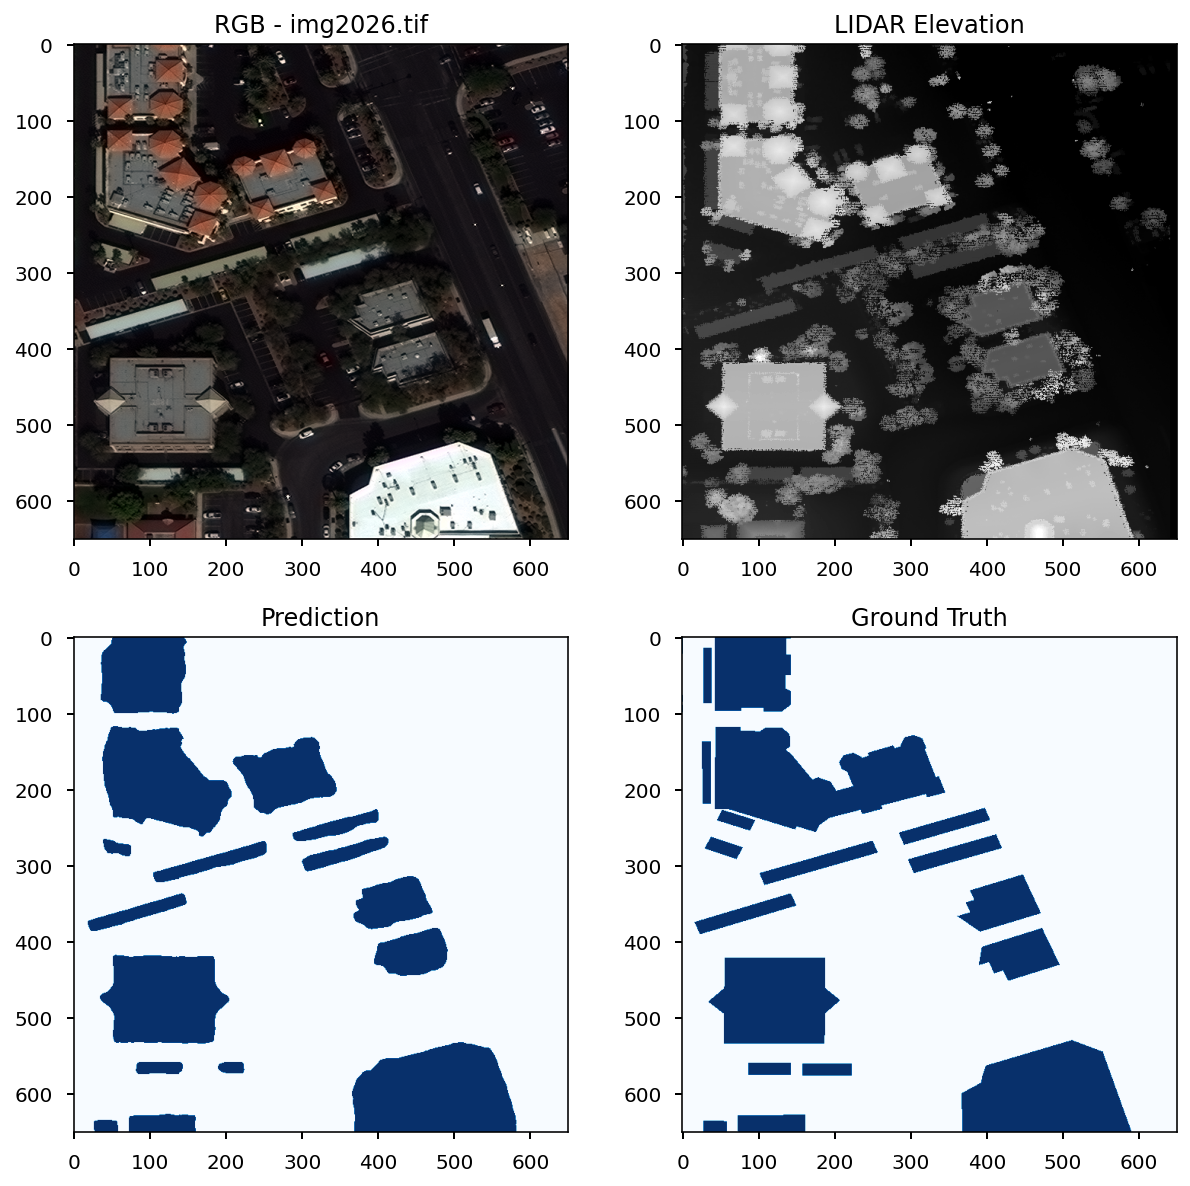

In [18]:
# Randomly check the network predictions. Feel free to rerun this cell!
file = random.choice(pred_file_list)
# Or you can select the 'img1423.tif' we saw before.
# file = 'SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img1423.tif'
img_path = os.path.join(img_dir, file)
pred_path = os.path.join(pred_dir, file)
mask_path = os.path.join(mask_dir, file.replace('RGB+ELEV', 'mask_buildings'))

img = skimage.io.imread(img_path)
rgb = img[..., :3]
elev = img[..., -1]
pred = skimage.io.imread(pred_path)[..., 0]
mask = skimage.io.imread(mask_path)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(rgb)
ax[0][0].set_title('RGB - {}'.format(file.split('_')[-1]))
ax[0][1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
ax[0][1].set_title('LIDAR Elevation')
ax[1][0].imshow(pred>0, cmap='Blues')
ax[1][0].set_title('Prediction')
ax[1][1].imshow(mask, cmap='Blues')
ax[1][1].set_title('Ground Truth')
fig.show()

### Paper figure

The following cell generates figure used in the tutorial proposal paper.

['SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img3352.tif', 'SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img5284.tif', 'SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img3414.tif']


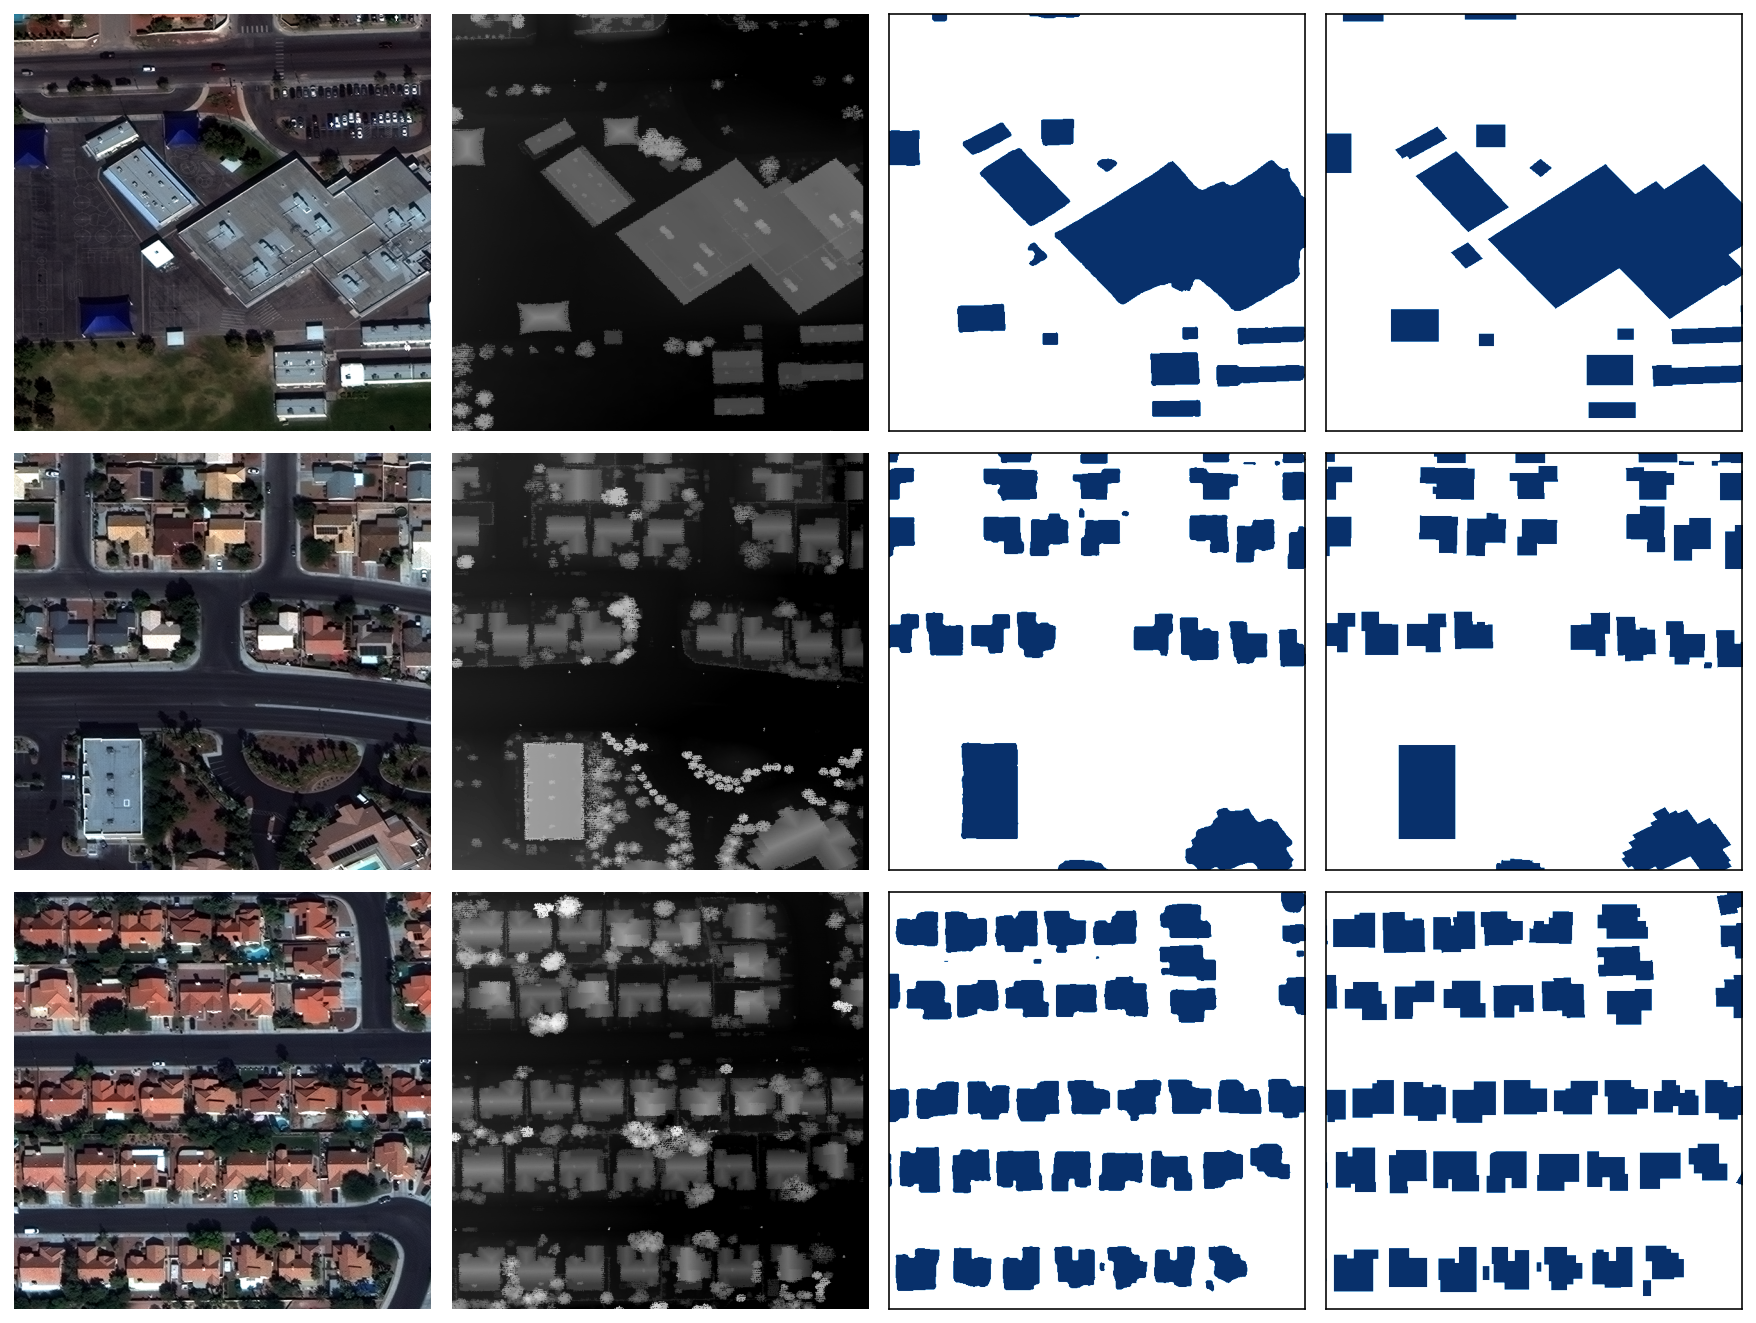

In [19]:
# img_sample_list = random.choices(pred_file_list, k=3)
img_sample_list = [
    'SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img3352.tif',
    'SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img5284.tif',
    'SN2_buildings_train_AOI_2_Vegas_RGB+ELEV_img3414.tif',
]
print(img_sample_list)

fig, ax = plt.subplots(3, 4, figsize=(12, 9))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.05, hspace=0.05)

for i, img_file in enumerate(img_sample_list):
    img_path = os.path.join(img_dir, img_file)
    img = skimage.io.imread(img_path)
    rgb = img[..., :3] # select RGB channels
    elev = img[..., -1]
    
    pred_path = os.path.join(pred_dir, img_file)
    pred = skimage.io.imread(pred_path)[..., 0]
    
    mask_file = img_file.replace('RGB+ELEV', 'mask_buildings')
    mask_path = os.path.join(mask_dir, mask_file)
    mask = skimage.io.imread(mask_path)
    
    row = ax[i]
    row[0].imshow(rgb)
    row[0].axis('off')
    row[1].imshow(elev, cmap='gray', vmin=0, vmax=5000)
    row[1].axis('off')
    row[2].imshow(pred>0, alpha=(pred>0).astype('float'), cmap='Blues')
    plt.setp(row[2].get_yticklabels(), visible=False)
    plt.setp(row[2].get_xticklabels(), visible=False)
    row[2].tick_params(axis='both', which='both', length=0)
    row[3].imshow(mask, alpha=(mask>0).astype('float'), cmap='Blues')
    plt.setp(row[3].get_yticklabels(), visible=False)
    plt.setp(row[3].get_xticklabels(), visible=False)
    row[3].tick_params(axis='both', which='both', length=0)
    
fig.show()

## Training comparison

The training logs are available in `data/buildings/train_logs/` directory for the three setups. Here are a comparison of them:

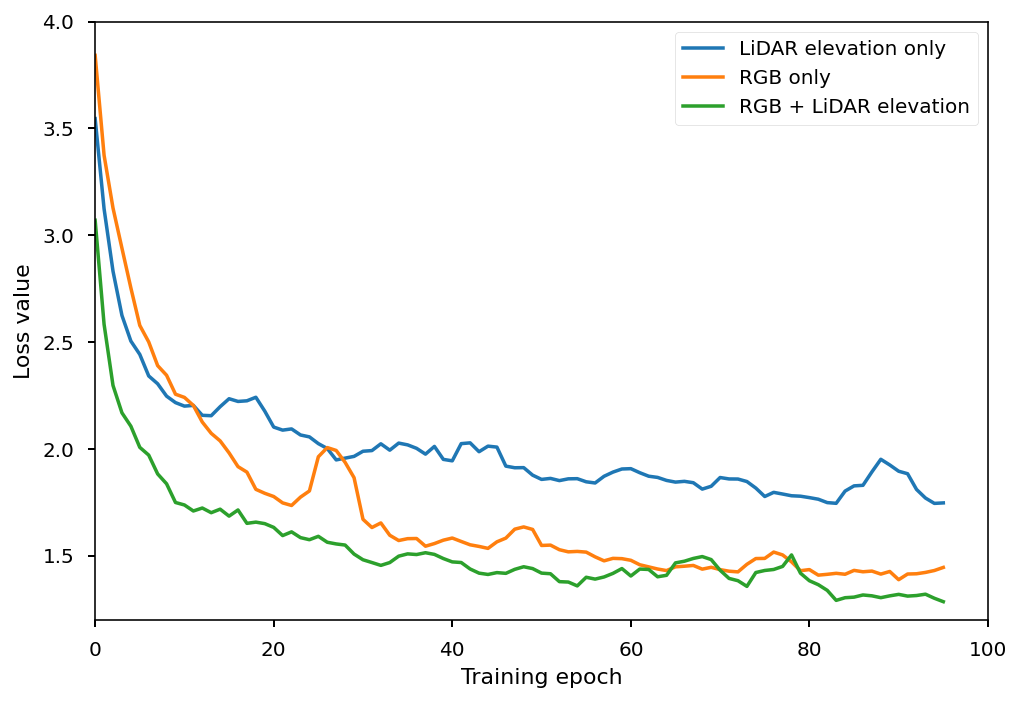

In [20]:
def log2data(logfile_path, smooth_n=5):
    f = open(logfile_path, 'r')
    content = f.read().split('\n')
    val_loss = [float(l.split(' ')[-1]) for l in content[13::15]]
    val_loss = np.convolve(val_loss, np.ones((smooth_n,))/smooth_n, mode='valid')
    return val_loss

both_loss = log2data('./data/buildings/train_logs/RGB+ELEV_train_log.txt')
rgb_loss = log2data('./data/buildings/train_logs/RGB-only_train_log.txt')
elev_loss = log2data('./data/buildings/train_logs/ELEV-only_train_log.txt')

plt.plot(elev_loss, label='LiDAR elevation only')
plt.plot(rgb_loss, label='RGB only')
plt.plot(both_loss, label='RGB + LiDAR elevation')
plt.ylabel('Loss value')
plt.ylim(1.2, 4)
plt.xlabel('Training epoch')
plt.xlim(0, 100)
plt.legend()
plt.show()

## This concludes the building extraction notebook.